#  Bulldozer Price Prediction with Structured Data and Regression Models

In this notebook, we're going to go through an example machine learning project with the goal of prediciting the sale price of bulldozers.

## 1. Problem Definition

> How well cane we predict the future sale price of a bulldozer, given its characterisitcs and previous examples of how much similar bulldozers have been sold for?

## 2. Data
The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.
  
## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

Note: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
# Import training and validation sets
df = pd.read_csv("Data/bluebook-for-bulldozers/TrainAndValid.csv",
                low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

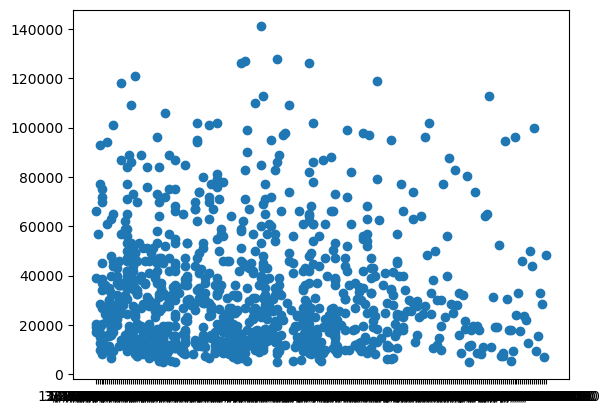

In [5]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

<Axes: ylabel='Frequency'>

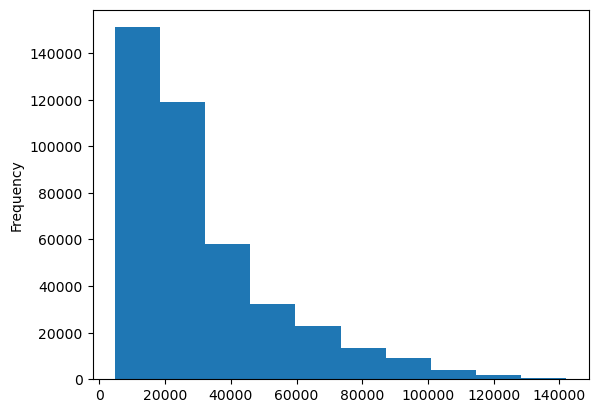

In [6]:
df.SalePrice.plot.hist()

### Parsing dates

when we work with time series data, we want to enrich the time and date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse dates` parameter

In [7]:
# Import data again but this time parse dates

df = pd.read_csv("Data/bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False, 
                 parse_dates=["saledate"])

In [8]:
df.saledate.dtype

dtype('<M8[ns]')

In [9]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

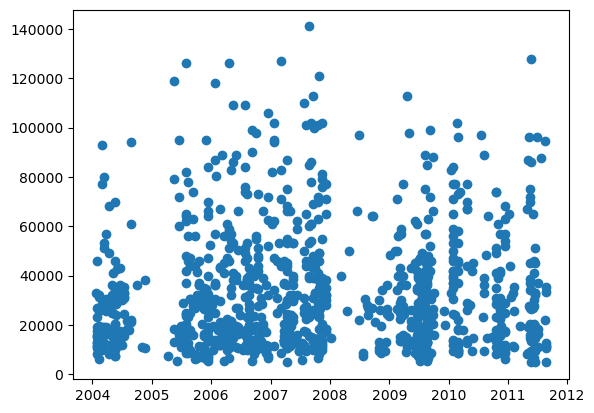

In [10]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [11]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [13]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

when we make a copy of the original dataframe so we can manipulate the copy, we've still got our original data.

In [14]:
# Make a copy
df_tmp = df.copy()

In [15]:
df_tmp.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Add datetime parameters for `saledate` column

In [16]:
# Add datetime parameters for saledate
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear
# Drop original saledate column
df_tmp.drop("saledate", axis=1, inplace=True)

In [17]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [18]:
# Check the values of different columns
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virgi

## 5. Modelling

We've done enought EDA but lets start to do more model-driven EDA.

In [21]:
# Lets build a machine learning model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

ValueError: could not convert string to float: 'Low'

In [22]:
df_tmp["UsageBand"].dtype

dtype('O')

In [23]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [24]:
# Check for missing values and different datatypes 
df_tmp.info();

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [25]:
# Find missing values in the head of our DataFrame 
df_tmp.head().isna()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
205615,False,False,False,False,False,False,False,True,True,False,...,False,False,False,True,True,False,False,False,False,False
274835,False,False,False,False,False,False,False,True,True,False,...,True,True,True,False,False,False,False,False,False,False
141296,False,False,False,False,False,False,False,True,True,False,...,False,False,False,True,True,False,False,False,False,False
212552,False,False,False,False,False,False,False,True,True,False,...,True,True,True,False,False,False,False,False,False,False
62755,False,False,False,False,False,False,False,True,True,False,...,False,False,False,True,True,False,False,False,False,False


### Convert string to categories 

one way we can turn all of our data into numbers is by converting them into pandas catergories.

We can check the different datatypes compatible with pandas here: https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality

In [26]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [27]:
# Get the dtype of a given column
df_tmp["UsageBand"].dtype, df_tmp["UsageBand"].dtype.name

(dtype('O'), 'object')

In [28]:
# Check whether a column is an object
pd.api.types.is_object_dtype(df_tmp["UsageBand"])

True

In [29]:
# Check whether a column is a string
pd.api.types.is_string_dtype(df_tmp["state"])

True

In [30]:
# If you're wondering what df.items() does, here's an example
random_dict = {"key1": "hello",
               "key2": "world!"}

for key, value in random_dict.items():
    print(f"this is a key: {key}",
          f"this is a value: {value}")

this is a key: key1 this is a value: hello
this is a key: key2 this is a value: world!


In [31]:
# Print column names and example content of columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        # Check datatype of target column
        column_datatype = df_tmp[label].dtype.name

        # Get random sample from column values
        example_value = content.sample(1).values

        # Infer random sample datatype
        example_value_dtype = pd.api.types.infer_dtype(example_value)
        print(f"Column name: {label} | Column dtype: {column_datatype} | Example value: {example_value} | Example value dtype: {example_value_dtype}")

Column name: fiModelDesc | Column dtype: object | Example value: ['IT24F'] | Example value dtype: string
Column name: fiBaseModel | Column dtype: object | Example value: ['312'] | Example value dtype: string
Column name: fiProductClassDesc | Column dtype: object | Example value: ['Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth'] | Example value dtype: string
Column name: state | Column dtype: object | Example value: ['Texas'] | Example value dtype: string
Column name: ProductGroup | Column dtype: object | Example value: ['BL'] | Example value dtype: string
Column name: ProductGroupDesc | Column dtype: object | Example value: ['Wheel Loader'] | Example value dtype: string


In [32]:
# Start a count of how many object type columns there are
number_of_object_type_columns = 0

for label, content in df_tmp.items():
    # Check to see if column is of object type (this will include the string columns)
    if pd.api.types.is_object_dtype(content): 
        # Check datatype of target column
        column_datatype = df_tmp[label].dtype.name

        # Get random sample from column values
        example_value = content.sample(1).values

        # Infer random sample datatype
        example_value_dtype = pd.api.types.infer_dtype(example_value)
        print(f"Column name: {label} | Column dtype: {column_datatype} | Example value: {example_value} | Example value dtype: {example_value_dtype}")

        number_of_object_type_columns += 1

print(f"\n[INFO] Total number of object type columns: {number_of_object_type_columns}")

Column name: UsageBand | Column dtype: object | Example value: ['Medium'] | Example value dtype: string
Column name: fiModelDesc | Column dtype: object | Example value: ['S175'] | Example value dtype: string
Column name: fiBaseModel | Column dtype: object | Example value: ['D9'] | Example value dtype: string
Column name: fiSecondaryDesc | Column dtype: object | Example value: [nan] | Example value dtype: empty
Column name: fiModelSeries | Column dtype: object | Example value: [nan] | Example value dtype: empty
Column name: fiModelDescriptor | Column dtype: object | Example value: [nan] | Example value dtype: empty
Column name: ProductSize | Column dtype: object | Example value: ['Mini'] | Example value dtype: string
Column name: fiProductClassDesc | Column dtype: object | Example value: ['Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth'] | Example value dtype: string
Column name: state | Column dtype: object | Example value: ['Florida'] | Example value dtype: string
Column name

In [33]:
# This will turn all of the object columns into category values
for label, content in df_tmp.items(): 
    if pd.api.types.is_object_dtype(content):
        df_tmp[label] = df_tmp[label].astype("category")

In [34]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [35]:
# Check the datatype of a single column
df_tmp.state.dtype

CategoricalDtype(categories=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
                  'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
                  'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
                  'Kentucky', 'Louisiana', 'Maine', 'Maryland',
                  'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
                  'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
                  'New Jersey', 'New Mexico', 'New York', 'North Carolina',
                  'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
                  'Puerto Rico', 'Rhode Island', 'South Carolina',
                  'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah',
                  'Vermont', 'Virginia', 'Washington', 'Washington DC',
                  'West Virginia', 'Wisconsin', 'Wyoming'],
, ordered=False, categories_dtype=object)

In [36]:
# Get the category names of a given column
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [37]:
# Inspect the category codes
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [38]:
# Get example string using category number
target_state_cat_number = 43
target_state_cat_value = df_tmp.state.cat.categories[target_state_cat_number] 
print(f"[INFO] Target state category number {target_state_cat_number} maps to: {target_state_cat_value}")

[INFO] Target state category number 43 maps to: Texas


Thanks to pandas Catergories we now have a way to access all of our data in the form of numbers.

    But we still have a bunch of missing data...

### Save preprocessed data 

In [39]:
# Save preprocessed data to file
df_tmp.to_csv("Data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories.csv",
              index=False)

In [40]:
# Import preprocessed data to file
df_tmp = pd.read_csv("Data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories.csv",
                     low_memory=False)

df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


In [41]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [42]:
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        # Turn object columns into category datatype
        df_tmp[label] = df_tmp[label].astype("category")

In [43]:
# Read in df_tmp from parquet format
!pip install pyarrow
df_tmp.to_parquet(path="Data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories.parquet", 
                  engine="auto") # "auto" will automatically use pyarrow or fastparquet, defaulting to pyarrow first

In [44]:
# Read in df_tmp from parquet format
df_tmp = pd.read_parquet(path="Data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories.parquet",
                         engine="auto")

# Using parquet format, datatypes are preserved
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

### Fill missing Values

#### Fill Numeric missing values first

In [45]:
# Check missing values
df_tmp.isna().sum().sort_values(ascending=False)[:20]

Blade_Width          386715
Enclosure_Type       386715
Engine_Horsepower    386715
Tip_Control          386715
Pushblock            386715
Blade_Extension      386715
Scarifier            386704
Grouser_Tracks       367823
Hydraulics_Flow      367823
Coupler_System       367724
fiModelSeries        354031
Steering_Controls    341176
Differential_Type    341134
UsageBand            339028
fiModelDescriptor    337882
Backhoe_Mounting     331986
Turbocharged         331602
Stick                331602
Pad_Type             331602
Blade_Type           330823
dtype: int64

In [46]:
# Find numeric columns 
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        # Check datatype of target column
        column_datatype = df_tmp[label].dtype.name

        # Get random sample from column values
        example_value = content.sample(1).values

        # Infer random sample datatype
        example_value_dtype = pd.api.types.infer_dtype(example_value)
        print(f"Column name: {label} | Column dtype: {column_datatype} | Example value: {example_value} | Example value dtype: {example_value_dtype}")

Column name: SalesID | Column dtype: int64 | Example value: [1621031] | Example value dtype: integer
Column name: SalePrice | Column dtype: float64 | Example value: [65000.] | Example value dtype: floating
Column name: MachineID | Column dtype: int64 | Example value: [1473303] | Example value dtype: integer
Column name: ModelID | Column dtype: int64 | Example value: [13398] | Example value dtype: integer
Column name: datasource | Column dtype: int64 | Example value: [132] | Example value dtype: integer
Column name: auctioneerID | Column dtype: float64 | Example value: [7.] | Example value dtype: floating
Column name: YearMade | Column dtype: int64 | Example value: [1000] | Example value dtype: integer
Column name: MachineHoursCurrentMeter | Column dtype: float64 | Example value: [3215.] | Example value dtype: floating
Column name: saleYear | Column dtype: int64 | Example value: [2010] | Example value dtype: integer
Column name: saleMonth | Column dtype: int64 | Example value: [6] | Exa

In [47]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(f"Column name: {label} | Has missing values: {True}")
        else:
            print(f"Column name: {label} | Has missing values: {False}")

Column name: SalesID | Has missing values: False
Column name: SalePrice | Has missing values: False
Column name: MachineID | Has missing values: False
Column name: ModelID | Has missing values: False
Column name: datasource | Has missing values: False
Column name: auctioneerID | Has missing values: True
Column name: YearMade | Has missing values: False
Column name: MachineHoursCurrentMeter | Has missing values: True
Column name: saleYear | Has missing values: False
Column name: saleMonth | Has missing values: False
Column name: saleDay | Has missing values: False
Column name: saleDayOfWeek | Has missing values: False
Column name: saleDayOfYear | Has missing values: False


In [48]:
# Fill missing numeric values with the median of the target column
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            
            # Add a binary column which tells if the data was missing our not
            df_tmp[label+"_is_missing"] = pd.isnull(content).astype(int) # this will add a 0 or 1 value to rows with missing values (e.g. 0 = not missing, 1 = missing)

            # Fill missing numeric values with median since it's more robust than the mean
            df_tmp[label] = content.fillna(content.median())

In [49]:
# Show rows where MachineHoursCurrentMeter_is_missing == 1
df_tmp[df_tmp["MachineHoursCurrentMeter_is_missing"] == 1].sample(5)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing
238031,1475701,21250.0,1478819,7277,132,5.0,1973,0.0,NaN,950,...,NaN,Standard,Conventional,2007,9,15,5,258,0,1
28258,1364579,10000.0,1078845,7289,132,2.0,1966,0.0,NaN,980,...,NaN,Standard,Conventional,1994,3,25,4,84,0,1
206552,1318049,85000.0,1519934,85,132,19.0,1998,0.0,NaN,966FII,...,NaN,Standard,Conventional,2006,6,30,4,181,0,1
67595,1806014,12500.0,1329942,9549,132,1.0,1996,0.0,NaN,751,...,NaN,NaN,NaN,1998,6,17,2,168,0,1
14331,1740779,9000.0,1410523,9046,132,1.0,1988,0.0,NaN,PC20,...,NaN,NaN,NaN,1991,12,10,1,344,0,1


In [50]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(f"Column name: {label} | Has missing values: {True}")
        else:
            print(f"Column name: {label} | Has missing values: {False}")
        

Column name: SalesID | Has missing values: False
Column name: SalePrice | Has missing values: False
Column name: MachineID | Has missing values: False
Column name: ModelID | Has missing values: False
Column name: datasource | Has missing values: False
Column name: auctioneerID | Has missing values: False
Column name: YearMade | Has missing values: False
Column name: MachineHoursCurrentMeter | Has missing values: False
Column name: saleYear | Has missing values: False
Column name: saleMonth | Has missing values: False
Column name: saleDay | Has missing values: False
Column name: saleDayOfWeek | Has missing values: False
Column name: saleDayOfYear | Has missing values: False
Column name: auctioneerID_is_missing | Has missing values: False
Column name: MachineHoursCurrentMeter_is_missing | Has missing values: False


In [51]:
# Check to see how many examples in the auctioneerID were missing
df_tmp.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
0    392562
1     20136
Name: count, dtype: int64

In [52]:
# Demonstrate how median is more robust than mean
hundreds = np.full((1000,), 100)
hundreds_billion = np.append(hundreds, 1000000000)
np.mean(hundreds), np.mean(hundreds_billion), np.median(hundreds), np.median(hundreds_billion)

(np.float64(100.0),
 np.float64(999100.8991008991),
 np.float64(100.0),
 np.float64(100.0))

In [53]:
# Check columns which aren't numeric
print(f"[INFO] Columns which are not numeric:")
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(f"Column name: {label} | Column dtype: {df_tmp[label].dtype.name}")

[INFO] Columns which are not numeric:
Column name: UsageBand | Column dtype: category
Column name: fiModelDesc | Column dtype: category
Column name: fiBaseModel | Column dtype: category
Column name: fiSecondaryDesc | Column dtype: category
Column name: fiModelSeries | Column dtype: category
Column name: fiModelDescriptor | Column dtype: category
Column name: ProductSize | Column dtype: category
Column name: fiProductClassDesc | Column dtype: category
Column name: state | Column dtype: category
Column name: ProductGroup | Column dtype: category
Column name: ProductGroupDesc | Column dtype: category
Column name: Drive_System | Column dtype: category
Column name: Enclosure | Column dtype: category
Column name: Forks | Column dtype: category
Column name: Pad_Type | Column dtype: category
Column name: Ride_Control | Column dtype: category
Column name: Stick | Column dtype: category
Column name: Transmission | Column dtype: category
Column name: Turbocharged | Column dtype: category
Column n

In [54]:
# 1. Create a dictionary to store column to category values (e.g. we turn our category types into numbers but we keep a record so we can go back)
column_to_category_dict = {} 

# 2. Turn categorical variables into numbers
for label, content in df_tmp.items():

    # 3. Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):

        # 4. Add binary column to inidicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content).astype(int)

        # 5. Ensure content is categorical and get its category codes
        content_categories = pd.Categorical(content)
        content_category_codes = content_categories.codes + 1 # prevents -1 (the default for NaN values) from being used for missing values (we'll treat missing values as 0)

        # 6. Add column key to dictionary with code: category mapping per column
        column_to_category_dict[label] = dict(zip(content_category_codes, content_categories))
        
        # 7. Set the column to the numerical values (the category code value) 
        df_tmp[label] = content_category_codes      

In [55]:
# Check the UsageBand (measure of bulldozer usage)
for key, value in sorted(column_to_category_dict["UsageBand"].items()): # note: calling sorted() on dictionary.items() sorts the dictionary by keys 
    print(f"{key} -> {value}")

0 -> nan
1 -> High
2 -> Low
3 -> Medium


In [56]:
# Check the first 10 state column values
for key, value in sorted(column_to_category_dict["state"].items())[:10]:
    print(f"{key} -> {value}")

1 -> Alabama
2 -> Alaska
3 -> Arizona
4 -> Arkansas
5 -> California
6 -> Colorado
7 -> Connecticut
8 -> Delaware
9 -> Florida
10 -> Georgia


In [57]:
# Check total number of missing values
total_missing_values = df_tmp.isna().sum().sum()

if total_missing_values == 0:
    print(f"[INFO] Total missing values: {total_missing_values} - Woohoo! Let's build a model!")
else:
    print(f"[INFO] Uh ohh... total missing values: {total_missing_values} - Perhaps we might have to retrace our steps to fill the values?")

[INFO] Total missing values: 0 - Woohoo! Let's build a model!


### Saving our preprocessed data PT.2

One more step before we train our new model!

let's save our work so we could re-import our preprocessed dataset if we wanted to.

We'll save it to the `parquet` format again, this time with a suffix to show we've filled the missing values.

In [58]:
# Save preprocessed data with object values as categories as well as missing values filled
df_tmp.to_parquet(path="Data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories_and_missing_values_filled.parquet",
                  engine="auto")

In [59]:
# Read in preprocessed dataset
df_tmp = pd.read_parquet(path="Data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories_and_missing_values_filled.parquet",
                         engine="auto")

In [60]:
# Check total number of missing values
total_missing_values = df_tmp.isna().sum().sum()

if total_missing_values == 0:
    print(f"[INFO] Total missing values: {total_missing_values} - Woohoo! Let's build a model!")
else:
    print(f"[INFO] Uh ohh... total missing values: {total_missing_values} - Perhaps we might have to retrace our steps to fill the values?")

[INFO] Total missing values: 0 - Woohoo! Let's build a model!


### 2.9 Fitting a machine learning model to our preprocessed data

In [61]:
%%time

# Sample 1000 samples with random state 42 for reproducibility
df_tmp_sample_1k = df_tmp.sample(n=1000, random_state=42)

# Instantiate a model
model = RandomForestRegressor(n_jobs=-1) # use -1 to utilise all available processors

# Create features and labels
X_sample_1k = df_tmp_sample_1k.drop("SalePrice", axis=1) # use all columns except SalePrice as X values
y_sample_1k = df_tmp_sample_1k["SalePrice"] # use SalePrice as y values (target variable)

# Fit the model to the sample data
model.fit(X=X_sample_1k, 
          y=y_sample_1k) 

CPU times: total: 1.97 s
Wall time: 492 ms


RandomForestRegressor(n_jobs=-1)

In [62]:
# Evaluate the model
model_sample_1k_score = model.score(X=X_sample_1k,
                                    y=y_sample_1k)

print(f"[INFO] Model score on {len(df_tmp_sample_1k)} samples: {model_sample_1k_score}")

[INFO] Model score on 1000 samples: 0.9556721233192993


In [63]:
%%time

# Instantiate model
model = RandomForestRegressor(n_jobs=-1) # note: this could take quite a while depending on your machine (it took ~1.5 minutes on my MacBook Pro M1 Pro with 10 cores)

# Create features and labels with entire dataset
X_all = df_tmp.drop("SalePrice", axis=1)
y_all = df_tmp["SalePrice"]

# Fit the model
model.fit(X=X_all, 
          y=y_all)

CPU times: total: 15min 52s
Wall time: 2min 47s


RandomForestRegressor(n_jobs=-1)

In [64]:
# Evaluate the model
model_sample_all_score = model.score(X=X_all,
                                     y=y_all)

print(f"[INFO] Model score on {len(df_tmp)} samples: {model_sample_all_score}")

[INFO] Model score on 412698 samples: 0.987545846853077


## 3. Splitting the data into the right train/validation sets

- Training data(`Train.csv`) = all samples up until 2011
- Validation data(`Valid.csv`) = all samples from January 1, 2012 - April 30, 2012.
- Testing data (`Test.csv`) = all samples May 1, 2012 - November 2012.

In [65]:
# Import train samples (making sure to parse dates and then sort by them)
train_df = pd.read_csv(filepath_or_buffer="Data/bluebook-for-bulldozers/Train.csv",
                       parse_dates=["saledate"],
                       low_memory=False).sort_values(by="saledate", ascending=True)

# Import validation samples (making sure to parse dates and then sort by them)
valid_df = pd.read_csv(filepath_or_buffer="Data/bluebook-for-bulldozers/Valid.csv",
                       parse_dates=["saledate"])

# The ValidSolution.csv contains the SalePrice values for the samples in Valid.csv
valid_solution = pd.read_csv(filepath_or_buffer="Data/bluebook-for-bulldozers/ValidSolution.csv")

# Map valid_solution to valid_df
valid_df["SalePrice"] = valid_df["SalesID"].map(valid_solution.set_index("SalesID")["SalePrice"])

# Make sure valid_df is sorted by saledate still
valid_df = valid_df.sort_values("saledate", ascending=True).reset_index(drop=True)

# How many samples are in each DataFrame?
print(f"[INFO] Number of samples in training DataFrame: {len(train_df)}")
print(f"[INFO] Number of samples in validation DataFrame: {len(valid_df)}")

[INFO] Number of samples in training DataFrame: 401125
[INFO] Number of samples in validation DataFrame: 11573


In [66]:
# Let's check out the training DataFrame
train_df.sample(5)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
237515,1738546,29000,1295377,327,132,5.0,1987,NaN,NaN,1996-09-28,...,32 inch,None or Unspecified,None or Unspecified,None or Unspecified,Triple,NaN,NaN,NaN,NaN,NaN
91497,1401116,16000,1186802,4090,132,1.0,1989,NaN,NaN,2006-04-20,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
165013,1588707,8000,1096318,8050,132,1.0,1971,NaN,NaN,1995-04-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66604,1338894,36000,1209513,3782,132,5.0,1994,NaN,NaN,2006-01-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
334847,2347983,14000,1765698,4603,136,1.0,1995,0.0,NaN,2008-03-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# And how about the validation DataFrame?
valid_df.sample(5)

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,SalePrice
10404,6269797,199100,1229,149,99,1993,NaN,NaN,2012-04-11,325L,...,None or Unspecified,Manual,Yes,Double,NaN,NaN,NaN,NaN,NaN,34200.0
2721,6267453,162293,3783,149,1,1998,NaN,NaN,2012-02-13,928G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,40000.0
10363,6280696,1923591,3783,149,2,1000,NaN,NaN,2012-04-10,928G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,48500.0
8341,6263800,1917000,4146,149,1,1968,NaN,NaN,2012-03-27,D8H,...,NaN,NaN,NaN,NaN,None or Unspecified,U,None or Unspecified,NaN,NaN,14000.0
6061,1225823,138367,3775,121,3,2001,11038.0,Medium,2012-03-08,924G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,34000.0


In [68]:
# Make a function to add date columns
def add_datetime_features_to_df(df, date_column="saledate"):
    # Add datetime parameters for saledate
    df["saleYear"] = df[date_column].dt.year
    df["saleMonth"] = df[date_column].dt.month
    df["saleDay"] = df[date_column].dt.day
    df["saleDayofweek"] = df[date_column].dt.dayofweek
    df["saleDayofyear"] = df[date_column].dt.dayofyear

    # Drop original saledate column
    df.drop("saledate", axis=1, inplace=True)

    return df

train_df = add_datetime_features_to_df(df=train_df)
valid_df = add_datetime_features_to_df(df=valid_df)

In [69]:
# Display the last 5 columns (the recently added datetime breakdowns)
train_df.iloc[:, -5:].sample(5)

,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
104327,2004,10,30,5,304
186405,1997,3,27,3,86
90351,2002,12,5,3,339
31801,2002,4,9,1,99
97907,2000,10,19,3,293


### 3.1 Trying to fit a model on our training data

In [71]:
# Split training data into features and labels
X_train = train_df.drop("SalePrice", axis=1)
y_train = train_df["SalePrice"]

# Split validation data into features and labels
X_valid = valid_df.drop("SalePrice", axis=1)
y_valid = valid_df["SalePrice"]

# Create a model
model = RandomForestRegressor(n_jobs=-1)

# Fit a model to the training data only
model.fit(X=X_train,
          y=y_train)

ValueError: could not convert string to float: 'Medium'

### 3.2 Encoding categorical features as numbers using Scikit-learn

In [72]:
# Define numerical and categorical features
numerical_features = [label for label, content in X_train.items() if pd.api.types.is_numeric_dtype(content)]
categorical_features = [label for label, content in X_train.items() if not pd.api.types.is_numeric_dtype(content)]

print(f"[INFO] Numeric features: {numerical_features}")
print(f"[INFO] Categorical features: {categorical_features[:10]}...")

[INFO] Numeric features: ['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'saleYear', 'saleMonth', 'saleDay', 'saleDayofweek', 'saleDayofyear']
[INFO] Categorical features: ['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup']...


In [73]:
from sklearn.preprocessing import OrdinalEncoder

# 1. Create an ordinal encoder (turns category items into numeric representation)
ordinal_encoder = OrdinalEncoder(categories="auto",
                                 handle_unknown="use_encoded_value",
                                 unknown_value=np.nan,
                                 encoded_missing_value=np.nan) # treat unknown categories as np.nan (or None)

# 2. Fit and transform the categorical columns of X_train
X_train_preprocessed = X_train.copy() # make copies of the oringal DataFrames so we can keep the original values in tact and view them later
X_train_preprocessed[categorical_features] = ordinal_encoder.fit_transform(X_train_preprocessed[categorical_features].astype(str)) # OrdinalEncoder expects all values as the same type (e.g. string or numeric only)

# 3. Transform the categorical columns of X_valid 
X_valid_preprocessed = X_valid.copy()
X_valid_preprocessed[categorical_features] = ordinal_encoder.transform(X_valid_preprocessed[categorical_features].astype(str)) # only use `transform` on the validation data

In [74]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
205615,1646770,1126363,8434,132,18.0,1974,NaN,NaN,TD20,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
92803,1404019,1169900,7110,132,99.0,1986,NaN,NaN,416,416,...,NaN,NaN,NaN,NaN,NaN,1989,1,31,1,31
98346,1415646,1262088,3357,132,99.0,1975,NaN,NaN,12G,12,...,NaN,NaN,NaN,NaN,NaN,1989,1,31,1,31
169297,1596358,1433229,8247,132,99.0,1978,NaN,NaN,644,644,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
274835,1821514,1194089,10150,132,99.0,1980,NaN,NaN,A66,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31


In [75]:
X_train_preprocessed.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
205615,1646770,1126363,8434,132,18.0,1974,NaN,3.0,4536.0,1734.0,...,0.0,7.0,5.0,4.0,5.0,1989,1,17,1,17
92803,1404019,1169900,7110,132,99.0,1986,NaN,3.0,734.0,242.0,...,2.0,10.0,7.0,4.0,5.0,1989,1,31,1,31
98346,1415646,1262088,3357,132,99.0,1975,NaN,3.0,81.0,18.0,...,2.0,10.0,7.0,4.0,5.0,1989,1,31,1,31
169297,1596358,1433229,8247,132,99.0,1978,NaN,3.0,1157.0,348.0,...,2.0,10.0,7.0,3.0,1.0,1989,1,31,1,31
274835,1821514,1194089,10150,132,99.0,1980,NaN,3.0,1799.0,556.0,...,2.0,10.0,7.0,3.0,1.0,1989,1,31,1,31


In [76]:
X_train[categorical_features].isna().sum().sort_values(ascending=False)[:10]

Tip_Control          375906
Enclosure_Type       375906
Engine_Horsepower    375906
Blade_Extension      375906
Blade_Width          375906
Pushblock            375906
Scarifier            375895
Grouser_Tracks       357763
Hydraulics_Flow      357763
Coupler_System       357667
dtype: int64

In [77]:
X_train_preprocessed[categorical_features].isna().sum().sort_values(ascending=False)[:10]

UsageBand             0
fiModelDesc           0
fiBaseModel           0
fiSecondaryDesc       0
fiModelSeries         0
fiModelDescriptor     0
ProductSize           0
fiProductClassDesc    0
state                 0
ProductGroup          0
dtype: int64

In [78]:
# Let's inspect the first three categories
ordinal_encoder.categories_[:3]

[array(['High', 'Low', 'Medium', 'nan'], dtype=object),
 array(['100C', '104', '1066', ..., 'ZX800LC', 'ZX80LCK', 'ZX850H'],
       shape=(4999,), dtype=object),
 array(['10', '100', '104', ..., 'ZX80', 'ZX800', 'ZX850'],
       shape=(1950,), dtype=object)]

In [79]:
# Create a dictionary of dictionaries mapping column names and their variables to their numerical encoding
column_to_category_mapping = {}

for column_name, category_values in zip(categorical_features, ordinal_encoder.categories_):
    int_to_category = {i: category for i, category in enumerate(category_values)}
    column_to_category_mapping[column_name] = int_to_category

# Inspect an example column name to category mapping
column_to_category_mapping["UsageBand"]

{0: 'High', 1: 'Low', 2: 'Medium', 3: 'nan'}

In [80]:
# Create a copy of the preprocessed DataFrame
X_train_unprocessed = X_train_preprocessed[categorical_features].copy()

# This will return an array of the original untransformed data
X_train_unprocessed = ordinal_encoder.inverse_transform(X_train_unprocessed)

# Turn back into a DataFrame for viewing pleasure
X_train_unprocessed_df = pd.DataFrame(X_train_unprocessed, columns=categorical_features)

# Check out a sample
X_train_unprocessed_df.sample(5)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
347828,nan,310SE,310,SE,nan,nan,nan,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,Maryland,BL,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
363900,nan,LX665,LX665,nan,nan,nan,nan,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,Arkansas,SSL,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
214854,nan,WA500,WA500,nan,nan,nan,Medium,Wheel Loader - 275.0 to 350.0 Horsepower,Washington,WL,...,nan,nan,nan,nan,nan,nan,nan,nan,Standard,Conventional
233251,nan,EX200,EX200,nan,nan,nan,Small,"Hydraulic Excavator, Track - 16.0 to 19.0 Metr...",Arizona,TEX,...,None or Unspecified,"9' 8""",Hydraulic,None or Unspecified,Double,nan,nan,nan,nan,nan
297062,nan,345BL,345,BL,nan,nan,Large / Medium,"Hydraulic Excavator, Track - 40.0 to 50.0 Metr...",Texas,TEX,...,None or Unspecified,"11' 0""",None or Unspecified,None or Unspecified,Double,nan,nan,nan,nan,nan


### 3.3 Fitting a model to our preprocessed training data

In [81]:
%%time

# Instantiate a Random Forest Regression model
model = RandomForestRegressor(n_jobs=-1)

# Fit the model to the preprocessed training data
model.fit(X=X_train_preprocessed,
          y=y_train)

CPU times: total: 13min 11s
Wall time: 2min 20s


RandomForestRegressor(n_jobs=-1)

In [82]:
%%time

# Check model performance on the validation set
model.score(X=X_valid,
            y=y_valid)

ValueError: could not convert string to float: 'Low'

In [83]:
%%time

# Check model performance on the validation set
model.score(X=X_valid_preprocessed,
            y=y_valid)

CPU times: total: 625 ms
Wall time: 131 ms


0.8711795046478056

In [84]:
%%time

# Check model performance on the training set
model.score(X=X_train_preprocessed,
            y=y_train)

CPU times: total: 18.8 s
Wall time: 3.47 s


0.9872583396308271

## 4. Building an evaluation function

In [85]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_absolute_error, root_mean_squared_log_error

# Create function to evaluate our model
def show_scores(model, 
                train_features=X_train_preprocessed,
                train_labels=y_train,
                valid_features=X_valid_preprocessed,
                valid_labels=y_valid):
    
    # Make predictions on train and validation features
    train_preds = model.predict(X=train_features)
    val_preds = model.predict(X=valid_features)

    # Create a scores dictionary of different evaluation metrics
    scores = {"Training MAE": mean_absolute_error(y_true=train_labels, 
                                                  y_pred=train_preds),
              "Valid MAE": mean_absolute_error(y_true=valid_labels, 
                                               y_pred=val_preds),
              "Training RMSLE": root_mean_squared_log_error(y_true=train_labels, 
                                                            y_pred=train_preds),
              "Valid RMSLE": root_mean_squared_log_error(y_true=valid_labels, 
                                                         y_pred=val_preds),
              "Training R^2": model.score(X=train_features, 
                                          y=train_labels),
              "Valid R^2": model.score(X=valid_features, 
                                       y=valid_labels)}
    return scores

In [86]:
# Try our model scoring function out
model_scores = show_scores(model=model)
model_scores

{'Training MAE': 1595.4281723236738,
 'Valid MAE': 6148.320019009764,
 'Training RMSLE': 0.08553311160940263,
 'Valid RMSLE': 0.25645411383690114,
 'Training R^2': 0.9872583396308271,
 'Valid R^2': 0.8711795046478056}

## 5. Tuning model's hyperparameters

### 5.1 Making our modelling experiments faster

In [87]:
%%time

# Change max samples in RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, # this is the default
                              n_jobs=-1,
                              max_samples=10000) # each estimator sees max_samples (the default is to see all available samples)

# Cutting down the max number of samples each tree can see improves training time
model.fit(X_train_preprocessed, 
          y_train)

CPU times: total: 28.2 s
Wall time: 5.44 s


RandomForestRegressor(max_samples=10000, n_jobs=-1)

In [88]:
# Get evaluation metrics from reduced sample model
base_model_scores = show_scores(model=model)
base_model_scores

{'Training MAE': 5606.432476775737,
 'Valid MAE': 7167.545326766323,
 'Training RMSLE': 0.2606331333933278,
 'Valid RMSLE': 0.2938199013804685,
 'Training R^2': 0.8582649849955177,
 'Valid R^2': 0.8303257458509758}

### 5.2 Hyperparameter tuning with RandomizedSearchCV

In [89]:
%%time

from sklearn.model_selection import RandomizedSearchCV

# 1. Define a dictionary with different values for RandomForestRegressor hyperparameters
# See documatation for potential different values - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html 
rf_grid = {"n_estimators": np.arange(10, 200, 10),
           "max_depth": [None, 10, 20],
           "min_samples_split": np.arange(2, 10, 1), # min_samples_split must be an int in the range [2, inf) or a float in the range (0.0, 1.0]
           "min_samples_leaf": np.arange(1, 10, 1),
           "max_features": [0.5, 1.0, "sqrt"], # Note: "max_features='auto'" is equivalent to "max_features=1.0", as of Scikit-Learn version 1.1
           "max_samples": [10000]}

# 2. Setup instance of RandomizedSearchCV to explore different parameters 
rs_model = RandomizedSearchCV(estimator=RandomForestRegressor(), # can pass new model instance directly, all settings will be taken from the rf_grid
                              param_distributions=rf_grid,
                              n_iter=20,
                            #   scoring="neg_root_mean_squared_log_error", # want to optimize for RMSLE, though sometimes optimizing for the default metric (R^2) can lead to just as good results all round
                              cv=3,
                              verbose=3) # control how much output gets produced, higher number = more output

# 3. Fit the model using a series of different hyperparameter values
rs_model.fit(X=X_train_preprocessed, 
             y=y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END max_depth=None, max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=5, n_estimators=150;, score=0.544 total time=  15.5s
[CV 2/3] END max_depth=None, max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=5, n_estimators=150;, score=0.759 total time=  15.5s
[CV 3/3] END max_depth=None, max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=5, n_estimators=150;, score=0.637 total time=  14.8s
[CV 1/3] END max_depth=10, max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=170;, score=0.491 total time=   5.6s
[CV 2/3] END max_depth=10, max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=170;, score=0.659 total time=   6.1s
[CV 3/3] END max_depth=10, max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=170;, score=0.632 total time=   5.6s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': [0.5, 1.0, 'sqrt'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
                   verbose=3)

In [90]:
# Find the best parameters from RandomizedSearchCV
rs_model.best_params_

{'n_estimators': np.int64(110),
 'min_samples_split': np.int64(4),
 'min_samples_leaf': np.int64(5),
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': 20}

In [91]:
# Evaluate the RandomizedSearch model
rs_model_scores = show_scores(rs_model)
rs_model_scores

{'Training MAE': 6053.400299049608,
 'Valid MAE': 7419.849754169217,
 'Training RMSLE': 0.27600800092752736,
 'Valid RMSLE': 0.30314920963811054,
 'Training R^2': 0.8361250332220552,
 'Valid R^2': 0.8186142892425341}

### 5.3 Training a model with the best hyperparameters

In [92]:
%%time

# Create a model with best found hyperparameters 
# Note: There may be better values out there with longer searches but these are 
# the best I found with a ~2 hour search. 
ideal_model = RandomForestRegressor(n_estimators=10,
                                    max_depth=None,
                                    min_samples_leaf=1,
                                    min_samples_split=5,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)

# Fit a model to the preprocessed data
ideal_model.fit(X=X_train_preprocessed, 
                y=y_train)

CPU times: total: 37.8 s
Wall time: 7.77 s


RandomForestRegressor(max_features=0.5, min_samples_split=5, n_estimators=10,
                      n_jobs=-1)

In [93]:
%%time

# Evaluate ideal model
ideal_model_scores = show_scores(model=ideal_model)
ideal_model_scores

CPU times: total: 3.12 s
Wall time: 858 ms


{'Training MAE': 2194.133861195837,
 'Valid MAE': 6331.529981027622,
 'Training RMSLE': 0.11457174636652463,
 'Valid RMSLE': 0.2618210056081608,
 'Training R^2': 0.974915414507817,
 'Valid R^2': 0.8679830358198353}

In [94]:
%%time

# Halve the number of estimators
fast_model = RandomForestRegressor(n_estimators=45,
                                   max_depth=None,
                                   min_samples_leaf=1,
                                   min_samples_split=5,
                                   max_features=0.5,
                                   n_jobs=-1,
                                   max_samples=None)

# Fit the faster model to the data
fast_model.fit(X=X_train_preprocessed, 
               y=y_train)

CPU times: total: 2min 51s
Wall time: 31.6 s


RandomForestRegressor(max_features=0.5, min_samples_split=5, n_estimators=45,
                      n_jobs=-1)

In [95]:
%%time

# Get results from the fast model
fast_model_scores = show_scores(model=fast_model)
fast_model_scores

CPU times: total: 15.9 s
Wall time: 3.21 s


{'Training MAE': 1995.859337004347,
 'Valid MAE': 6021.851463793628,
 'Training RMSLE': 0.10402971949966743,
 'Valid RMSLE': 0.2490272193507852,
 'Training R^2': 0.9801264583030697,
 'Valid R^2': 0.8792125072513635}

### 5.4 Comparing our model's scores

In [97]:
# Add names of models to dictionaries
base_model_scores["model_name"] = "default_model"
rs_model_scores["model_name"] = "random_search_model"
ideal_model_scores["model_name"] = "ideal_model" 
fast_model_scores["model_name"] = "fast_model" 

# Turn all model score dictionaries into a list
all_model_scores = [base_model_scores, 
                    rs_model_scores, 
                    ideal_model_scores,
                    fast_model_scores]

# Create DataFrame and sort model scores by validation RMSLE
model_comparison_df = pd.DataFrame(all_model_scores).sort_values(by="Valid RMSLE", ascending=False)
model_comparison_df.head()

,Training MAE,Valid MAE,Training RMSLE,Valid RMSLE,Training R^2,Valid R^2,model_name
1,6053.400299,7419.849754,0.276008,0.303149,0.836125,0.818614,random_search_model
0,5606.432477,7167.545327,0.260633,0.293820,0.858265,0.830326,default_model
2,2194.133861,6331.529981,0.114572,0.261821,0.974915,0.867983,ideal_model
3,1995.859337,6021.851464,0.104030,0.249027,0.980126,0.879213,fast_model


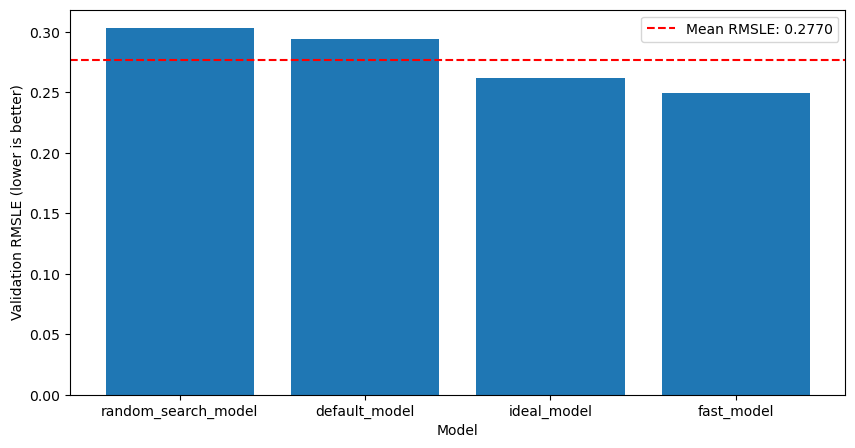

In [98]:
# Get mean RSMLE score of all models
mean_rsmle_score = model_comparison_df["Valid RMSLE"].mean()

# Plot validation RMSLE against each other 
plt.figure(figsize=(10, 5))
plt.bar(x=model_comparison_df["model_name"],
        height=model_comparison_df["Valid RMSLE"].values)
plt.xlabel("Model")
plt.ylabel("Validation RMSLE (lower is better)")
plt.xticks(rotation=0, fontsize=10);
plt.axhline(y=mean_rsmle_score, 
            color="red", 
            linestyle="--", 
            label=f"Mean RMSLE: {mean_rsmle_score:.4f}")
plt.legend();

## 6. Saving best model to file

In [100]:
import joblib

bulldozer_price_prediction_model_name = "randomforest_regressor_best_RMSLE.pkl"

# Save model to file
joblib.dump(value=ideal_model, 
            filename=bulldozer_price_prediction_model_name)

['randomforest_regressor_best_RMSLE.pkl']

In [101]:
# Load the best model
best_model = joblib.load(filename=bulldozer_price_prediction_model_name)
best_model

RandomForestRegressor(max_features=0.5, min_samples_split=5, n_estimators=10,
                      n_jobs=-1)

In [102]:
# Confirm that the model works
best_model_scores = show_scores(model=best_model)
best_model_scores

{'Training MAE': 2194.133861195837,
 'Valid MAE': 6331.529981027623,
 'Training RMSLE': 0.11457174636652463,
 'Valid RMSLE': 0.2618210056081608,
 'Training R^2': 0.974915414507817,
 'Valid R^2': 0.8679830358198353}

In [103]:
# See if loaded model and pre-saved model results are the same
# Note: these values may be very slightly different depending on how precise your computer stores values.
best_model_scores["Valid RMSLE"] == ideal_model_scores["Valid RMSLE"]

True

In [104]:
# Is the loaded model as good as the non-loaded model?
if np.isclose(a=best_model_scores["Valid RMSLE"], 
              b=ideal_model_scores["Valid RMSLE"],
              atol=1e-4): # Make sure values are within 0.0001 of each other
    print(f"[INFO] Model results are close!")
else:
    print(f"[INFO] Model results aren't close, did something go wrong?")

[INFO] Model results are close!


## 7. Making predictions on test data

In [106]:
# Load the test data
test_df = pd.read_csv(filepath_or_buffer="Data/bluebook-for-bulldozers/Test.csv",
                      parse_dates=["saledate"])
test_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [107]:
# Let's see how the model goes predicting on the test data
test_preds = best_model.predict(X=test_df)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- saleDay
- saleDayofweek
- saleDayofyear
- saleMonth
- saleYear


### 7.1 Preprocessing the test data ( to be in same format as the training data)

In [109]:
# Make a function to add date columns
def add_datetime_features_to_df(df, date_column="saledate"):
    # Add datetime parameters for saledate
    df["saleYear"] = df[date_column].dt.year
    df["saleMonth"] = df[date_column].dt.month
    df["saleDay"] = df[date_column].dt.day
    df["saleDayofweek"] = df[date_column].dt.dayofweek
    df["saleDayofyear"] = df[date_column].dt.dayofyear

    # Drop original saledate column
    df.drop("saledate", axis=1, inplace=True)

    return df

# Preprocess test_df to have same columns as train_df (add the datetime features)
test_df = add_datetime_features_to_df(df=test_df)
test_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
0,1227829,1006309,3168,121,3,1999,3688.0,Low,580G,580,...,NaN,NaN,NaN,NaN,NaN,2012,5,3,3,124
1,1227844,1022817,7271,121,3,1000,28555.0,High,936,936,...,NaN,NaN,NaN,Standard,Conventional,2012,5,10,3,131
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,EC210BLC,EC210,...,NaN,NaN,NaN,NaN,NaN,2012,5,10,3,131
3,1227848,56204,1269,121,3,2006,8940.0,High,330CL,330,...,NaN,NaN,NaN,NaN,NaN,2012,5,10,3,131
4,1227863,1053887,22312,121,3,2005,2286.0,Low,650K,650,...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,5,10,3,131


In [110]:
# Try to predict with model
test_preds = best_model.predict(test_df)

ValueError: could not convert string to float: 'Low'

In [111]:
# Create a copy of the test DataFrame to keep the original intact
test_df_preprocessed = test_df.copy()

# Transform the categorical features of the test DataFrame into numbers
test_df_preprocessed[categorical_features] = ordinal_encoder.transform(test_df_preprocessed[categorical_features].astype(str))
test_df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   12457 non-null  int64  
 1   MachineID                 12457 non-null  int64  
 2   ModelID                   12457 non-null  int64  
 3   datasource                12457 non-null  int64  
 4   auctioneerID              12457 non-null  int64  
 5   YearMade                  12457 non-null  int64  
 6   MachineHoursCurrentMeter  2129 non-null   float64
 7   UsageBand                 12457 non-null  float64
 8   fiModelDesc               12349 non-null  float64
 9   fiBaseModel               12431 non-null  float64
 10  fiSecondaryDesc           12449 non-null  float64
 11  fiModelSeries             12456 non-null  float64
 12  fiModelDescriptor         12452 non-null  float64
 13  ProductSize               12457 non-null  float64
 14  fiProd

In [112]:
# Make predictions on the preprocessed test data
test_preds = best_model.predict(test_df_preprocessed)

In [113]:
# Check the first 10 test predictions
test_preds[:10]

array([14213.33333333, 27941.66666667, 49589.52380952, 98161.19047619,
       26440.        , 29814.58333333, 25970.53571429, 22651.09126984,
       17681.66666667, 38454.88095238])

In [114]:
# Check number of test predictions
test_preds.shape, test_df.shape

((12457,), (12457, 56))

In [115]:
# Create DataFrame compatible with Kaggle submission requirements
pred_df = pd.DataFrame()
pred_df["SalesID"] = test_df["SalesID"]
pred_df["SalePrice"] = test_preds
pred_df.sample(5)

,SalesID,SalePrice
10652,6626635,81766.666667
10413,6624702,31483.333333
12360,6640462,79308.333333
7067,6312029,16379.523810
7465,6320244,41518.988095


In [117]:
# Export test dataset predictions to CSV
pred_df.to_csv("Data/bluebook-for-bulldozers/predictions.csv",
               index=False)

## 8. Making a prediction on a custom sample

In [119]:
# Get example from test_df
test_df_preprocessed_sample = test_df_preprocessed.sample(n=1, random_state=42)

# Turn back into original format
test_df_unpreprocessed_sample = test_df_preprocessed_sample.copy() 
test_df_unpreprocessed_sample[categorical_features] = ordinal_encoder.inverse_transform(test_df_unpreprocessed_sample[categorical_features])
test_df_unpreprocessed_sample.to_dict(orient="records")

[{'SalesID': 1229148,
  'MachineID': 1042578,
  'ModelID': 9579,
  'datasource': 121,
  'auctioneerID': 3,
  'YearMade': 2004,
  'MachineHoursCurrentMeter': 3290.0,
  'UsageBand': 'Medium',
  'fiModelDesc': 'S250',
  'fiBaseModel': 'S250',
  'fiSecondaryDesc': 'nan',
  'fiModelSeries': 'nan',
  'fiModelDescriptor': 'nan',
  'ProductSize': 'nan',
  'fiProductClassDesc': 'Skid Steer Loader - 2201.0 to 2701.0 Lb Operating Capacity',
  'state': 'Missouri',
  'ProductGroup': 'SSL',
  'ProductGroupDesc': 'Skid Steer Loaders',
  'Drive_System': 'nan',
  'Enclosure': 'EROPS',
  'Forks': 'None or Unspecified',
  'Pad_Type': 'nan',
  'Ride_Control': 'nan',
  'Stick': 'nan',
  'Transmission': 'nan',
  'Turbocharged': 'nan',
  'Blade_Extension': 'nan',
  'Blade_Width': 'nan',
  'Enclosure_Type': 'nan',
  'Engine_Horsepower': 'nan',
  'Hydraulics': 'Auxiliary',
  'Pushblock': 'nan',
  'Ripper': 'nan',
  'Scarifier': 'nan',
  'Tip_Control': 'nan',
  'Tire_Size': 'nan',
  'Coupler': 'Hydraulic',
  'C

In [120]:
# Make a prediction on the preprocessed test sample
best_model.predict(test_df_preprocessed_sample)

array([13900.23809524])

## 9. Find most important predictive features

In [121]:
# Find feature importance of our best model
best_model_feature_importances = best_model.feature_importances_
best_model_feature_importances

array([3.43746294e-02, 3.92741559e-02, 5.14634366e-02, 2.72498413e-03,
       5.29660883e-03, 1.77442031e-01, 6.88905283e-03, 1.34931870e-03,
       5.87507036e-02, 5.34110624e-02, 3.53673857e-02, 4.43290291e-03,
       3.93482818e-02, 1.29302267e-01, 5.20648090e-02, 8.38727569e-03,
       2.48863609e-03, 3.02286766e-03, 1.51952536e-03, 7.62374208e-02,
       1.43143465e-03, 1.26855886e-03, 1.54776139e-03, 1.55550626e-04,
       1.25280638e-03, 4.66862164e-04, 3.46898342e-03, 4.30249324e-04,
       1.71837307e-03, 1.82378845e-03, 1.08683787e-02, 1.90963626e-03,
       5.78823464e-03, 2.07802122e-03, 3.34199714e-03, 1.18495739e-02,
       1.55302098e-03, 2.29986851e-02, 2.54256668e-03, 1.97310516e-02,
       1.73063709e-03, 2.15073470e-03, 1.31261020e-03, 7.74191755e-04,
       7.81394883e-04, 8.13594470e-04, 4.52110044e-04, 3.86588384e-03,
       4.22334176e-03, 4.84325967e-04, 4.91971936e-04, 7.21784981e-02,
       5.56349748e-03, 8.66845109e-03, 4.46757091e-03, 1.26682955e-02])

In [122]:
print(f"[INFO] Number of feature importance values: {best_model_feature_importances.shape[0]}") 
print(f"[INFO] Number of features in training dataset: {X_train_preprocessed.shape[1]}")

[INFO] Number of feature importance values: 56
[INFO] Number of features in training dataset: 56


In [123]:
# Create feature importance DataFrame
column_names = test_df.columns
feature_importance_df = pd.DataFrame({"feature_names": column_names,
                                      "feature_importance": best_model_feature_importances}).sort_values(by="feature_importance",
                                                                                                         ascending=False)
feature_importance_df.head()

,feature_names,feature_importance
5,YearMade,0.177442
13,ProductSize,0.129302
19,Enclosure,0.076237
51,saleYear,0.072178
8,fiModelDesc,0.058751


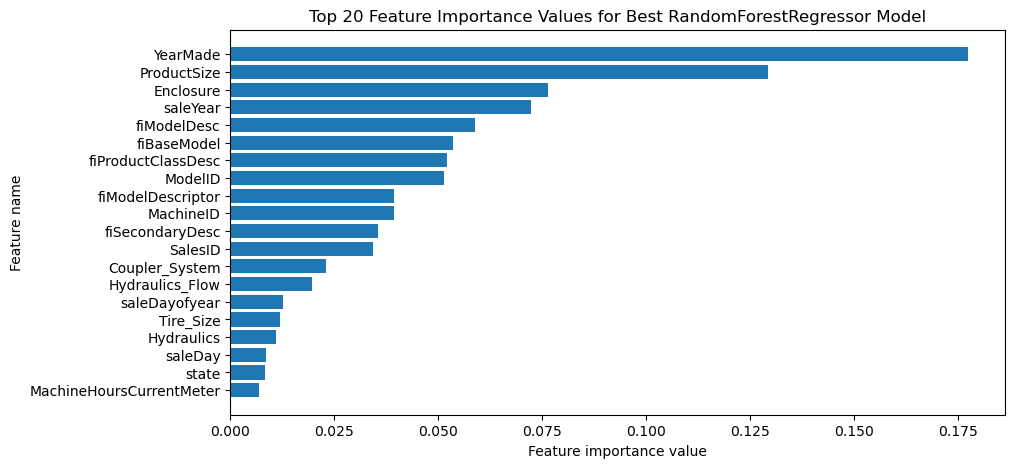

In [124]:
# Plot the top feature importance values
top_n = 20
plt.figure(figsize=(10, 5))
plt.barh(y=feature_importance_df["feature_names"][:top_n], # Plot the top_n feature importance values
         width=feature_importance_df["feature_importance"][:top_n])
plt.title(f"Top {top_n} Feature Importance Values for Best RandomForestRegressor Model")
plt.xlabel("Feature importance value")
plt.ylabel("Feature name")
plt.gca().invert_yaxis();

In [125]:
print(f"[INFO] Unique ProductSize values: {train_df['ProductSize'].unique()}")
print(f"[INFO] Unique Enclosure values: {train_df['Enclosure'].unique()}")

[INFO] Unique ProductSize values: ['Medium' nan 'Compact' 'Small' 'Large' 'Large / Medium' 'Mini']
[INFO] Unique Enclosure values: ['OROPS' 'EROPS' 'EROPS w AC' nan 'EROPS AC' 'NO ROPS'
 'None or Unspecified']
